#Classes to be implemented


*   TheWorld [DONE]
*   User [DONE]
*   AI_Assistant [random policy: DONE]
    *   Environment [DONE]
    *   Planner [WIP]
    *   UserModel [WIP]





## Easy Navigation
* [Obj dev area](#dev)
* [Code testing area](#testing)
* [Tutorial starts here](#start)
    * [Initialization](#init)
    * [Task 1: Implement user model](#task1)
    <!--     * [Task 1 part i](#task_11)
        * [Task 1 part ii](#task_12)
        * [Task 1 part iii](#task_13) -->
    * [Task 2: Implement param inference](#task2)
    <!--     * [Case study i: "all coins display tails"](#task_21)
        * [Case study ii: at least "1 coin display tails" ](#task_22)
        * [(Bonus) Case study iii: "Exactly 1 tail"  ](#task_23) -->
    * [Task 3: Implement interaction loop](#task3)
    <!--     * [Task 3 part i](#task_31)
        * [(Optional) Task 3 part ii](#task_32)
        * [Task 3 part iii](#task_33)
            * [Plot by mean/SD value](#task_33_abs)
            * [Plot by RMSE](#task_33_rmse) -->

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, multivariate_normal
from scipy.optimize import minimize
import copy
from tutorialObjs import World, UserModel, Route, Env, crUser

# Obj dev area <a class="anchor" id="dev"></a>

In [48]:
class UserModel:
    def __init__(self,simUser=True,**kwargs):
        self.role = "sim" if simUser else "user"
        
        # read in overwrites
        self.param_dist = kwargs.get('distribution', 
                                     multivariate_normal())
        self.user_params = kwargs.get('user_params', 
                                      self.param_dist.rvs(3))
        self.policy_fn = kwargs.get('policy', None)
        self.inf_fn = kwargs.get('inference', None)
        
        # verify tutorial excercise overwrites
        if self.policy_fn is not None:
            assert callable(self.policy_fn)
        if self.inf_fn is not None:
            assert callable(self.inf_fn)
        
        
        self.world_setup = None
        self.observations = []
            
        if self.role == 'sim':
            self.param_dist = multivariate_normal(mean=self.user_params)
        elif self.role == 'user':
            self.error = np.random.uniform(0,.3)

    def take_action(self,**kwargs):
        assert len(self.observations) > 0, "observe() needs to be called first"
        ai_advice, advice_costs = self.observations[-1]
#         ai_advice = [r.get_itinerary() for r in last_ai]
#         advice_costs = [self._calc_segment_cost(segment) for segment in ai_advice]
        # COULD DO: make Boltzmann ration as well
        most_costly = np.argmax(advice_costs)
        all_paths, cost_vec = self._find_alternatives(ai_advice,most_costly)
       
        if self.policy_fn is not None:
            actions, action_prob = self.policy_fn(all_paths,self.user_params)
        else:
            actions, action_prob = self.policy(all_paths,cost_vec)
        
        sampled_ind = np.random.choice(range(len(actions)),p=action_prob)
        return actions[sampled_ind]
        
    def policy(self,all_actions,cost_vec):
        action_cost = np.array(cost_vec)
        action_probs = np.exp(action_cost)/np.sum(np.exp(action_cost))

        # COULD DO: In case we need more stochasticity
        # make_error = bernoulli(self.error)
        # if make_error:
        #     new_path_dict.drop(preferred_path)
        #     return np.random.choice(list(new_path_dict.values()))
        return all_actions, action_probs
    
    def _calc_segment_cost(self,segment):
        if isinstance(segment,Route):
            cost_vec = segment.get_costs()
        else:
            cost_vec = np.array([self.world_setup['dists'][segment], 
                                 self.world_setup['prices'][segment],
                                 self.world_setup['times'][segment]])
        return self.user_params.dot(cost_vec)       

    def _find_alternatives(self,path,costly_ind):        
        alt_dict = dict()
        start, mid_pt, mode = path[costly_ind]
        
        # change mode of transport
        bin_modes = self.world_setup['edges'][start, mid_pt]
        alt_modes = [i for i, val in enumerate(bin_modes) if val=='1']
        for mode_num in alt_modes:
            new_mode = (start,mid_pt,mode_num)
            alt_dict[new_mode] = self._calc_segment_cost(new_mode)
            
        print("change mode: ", alt_dict)
        
        if path[costly_ind] != path[-1]:
            # find alternative transfer routes
            _, end, mode = path[costly_ind+1]
            ## skip
            bin_direct = self.world_setup['edges'][start, end]
            alt_direct = [i for i, val in enumerate(bin_direct) if val=='1']
            for mode_num in alt_direct:
                new_direct = (start,end,mode_num)
                alt_dict[new_direct] = self._calc_segment_cost(new_direct)
            print("skip connection: ", alt_dict)

            ## change transfer
            alt_transfer1 = self.world_setup['edges'][start, :]
            for mid_pt, bin_transfer1 in enumerate(alt_transfer1):
                txn_dict = dict()
                alt_tnx1 = [i for i, v in enumerate(bin_transfer1) if v=='1']
                for mode_num in alt_tnx1:
                    txn1 = (start,mid_pt,mode_num)
                    txn_dict[txn1] = self._calc_segment_cost(txn1)
                bin_tnx2 = self.world_setup['edges'][mid_pt, end]
                alt_tnx2 = [i for i, v in enumerate(bin_tnx2) if v=='1']
                for mode_num in alt_tnx2:
                    txn2 = (mid_pt,end,mode_num)
                    cost2 = self._calc_segment_cost(txn2)
                    for txn1,cost1 in txn_dict.items():
                        alt_dict[(txn1,txn2)] = cost1 + cost2
            print("Transfer: ", alt_dict)

        # Build list of alternatives/counter proposals + their costs
        ai_advice, advice_costs = self.observations[-1]
        all_paths, cost_vec = [],[]
        for journey, cost in alt_dict.items():
            new_path = copy.copy(ai_advice)
            new_costs = copy.copy(advice_costs)
            if len(journey)==3:
                new_path[costly_ind] = journey
                new_costs[costly_ind] = cost
                
                _,new_e,_ = journey
                _,old_e,_ = new_path[costly_ind+1]
                if new_e == old_e:
                    del new_path[costly_ind+1]
                    del new_costs[costly_ind+1]
                
            elif len(journey)==2:
                part1, part2 = journey
                new_path[most_costly] = part1
                new_path.insert(most_costly+1,part2)
                new_costs[costly_ind] = cost
            all_paths.append(new_path)
            cost_vec.append(np.sum(new_costs))
        
        return all_paths, cost_vec
    
    def observe(self,state):
        # If first time seeing the board
        if self.world_setup is None:
            self.world_setup = dict()
            self.world_setup['edges'] = np.array(state.bin_edges)
            self.world_setup['prices'] = state.prices
            self.world_setup['times'] = state.times
            self.world_setup['dists'] = state.dists
        if state.path_ai is not None:
            ai_advice = [r.get_itinerary() for r in state.path_ai]
            advice_costs = [self._calc_segment_cost(segment) for segment in ai_advice]
            self.observations.append((ai_advice,advice_costs))
            
    def sample(self):
        assert self.role=='sim', "Method only available to simulated users; method called on true user."
        return self.param_dist.rvs(size=self.user_params.shape)
    
    def update(self, obs,**kwargs):
        assert self.role=='sim', "Method only available to simulated users; method called on true user."
        
        if self.inf_fn is not None:
            return self.inf_fn(obs,**kwargs)
        
#         if obs.path_ai != obs.path_user:
        if not task_state.is_solved():
            # step 1: check what user changed
            ai_advice = [s.get_itinerary() for s in obs.path_ai]
            changes = [s for s in obs.path_user if s.get_itinerary() not in ai_advice]
            for c in changes:
                cost_vec = c.get_costs()

                # step 2: Use Laplace Approx for posterior
                # Debug idea: change init value every time
                init_mean = self.param_dist.mean
                optim = minimize(self._log_posterior, init_mean,
                                 args=(cost_vec,"L1"), method='BFGS')
                if not optim.success:
                    print("Failed to minimize")
                w_map = optim.x/np.sum(optim.x)
                hessian = np.linalg.inv(optim.hess_inv)

#                 print(w_map,np.any(hessian<0))
#                 print(hessian)
                self.param_dist = multivariate_normal(mean=w_map,
                                                      cov=hessian)
            
    def _log_posterior(self,w,a,regularizer=None):
#         w_mu = self.param_dist.mean
#         w_cov = self.param_dist.cov
#         log_prior = (w - w_mu).dot(np.linalg.inv(w_cov)).dot(w - w_mu)
#         if not np.isclose(np.sum(w),1):
#             w = w/np.sum(w)
        log_prior = self.param_dist.logpdf(w)
        log_likelihood = w.dot(a) 
        
        if regularizer == "L1":
            l1_reg = np.sum(np.abs(w))
            return -1*(log_prior + log_likelihood + np.log(l1_reg))
#         elif regularizer == "L2":    # Optimization yields invalid Hessian for covar matrix
#             l2_reg = np.sum(np.square(w))
#             return -1*(log_prior + log_likelihood + l2_reg)
            
        return -1*(log_prior + log_likelihood)

In [10]:
# class Planner:
#     def __init__(self):
#         pass
#     def _plan(self):
#         pass
#     def _select_best(self,actions,user_params):
#         for

#     def recommend(self,env,user_model):
#         param_sample = user_model.sample()
#         all_actions = env.all_actions
#         action = self._select_best(self.all_actions,param_sample)
#         return actions, action_pr

In [98]:
class testUserModel(UserModel):
    # implement user cross over
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    def update(self, obs):
        if obs.path_ai != obs.path_user:
            # step 1: check what user changed
            ai_advice = [s.get_itinerary() for s in obs.path_ai]
            changes = [s for s in obs.path_user if s.get_itinerary() not in ai_advice]
            for c in changes:
                cost_vec = c.get_costs()

                # step 2: Use Laplace Approx for posterior
                # Debug idea: change init value every time
                init_mean = self.param_dist.mean
                optim = minimize(self._log_posterior, init_mean,
                                 args=(cost_vec,"L1"), method='BFGS')
                if not optim.success:
                    print("Failed to minimize")
                w_map = optim.x/np.sum(optim.x)
                hessian = np.linalg.inv(optim.hess_inv)

#                 print(w_map,np.any(hessian<0))
#                 print(hessian)
                self.param_dist = multivariate_normal(mean=w_map,
                                                      cov=hessian)

    def _log_posterior(self,w,a,regularizer=None):
#         w_mu = self.param_dist.mean
#         w_cov = self.param_dist.cov
#         log_prior = (w - w_mu).dot(np.linalg.inv(w_cov)).dot(w - w_mu)
#         if not np.isclose(np.sum(w),1):
#             w = w/np.sum(w)
        log_prior = self.param_dist.logpdf(w)
        log_likelihood = w.dot(a) 
        
        if regularizer == "L1":
            l1_reg = np.sum(np.abs(w))
            return -1*(log_prior + log_likelihood + np.log(l1_reg))
#         elif regularizer == "L2":    # Optimization yields invalid Hessian for covar matrix
#             l2_reg = np.sum(np.square(w))
#             return -1*(log_prior + log_likelihood + l2_reg)
            
        return -1*(log_prior + log_likelihood)
    
    def sample(self):
        return self.param_dist.rvs(size=self.user_params.shape)

## Testing area <a class="anchor" id="testing"></a>

In [2]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



world = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)

# ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
# world.step(ai_advice=ai_advice)

<Figure size 700x600 with 0 Axes>

In [99]:
true_b = np.array([1,1,1])/3
b_0 = np.array([.1,.05,.8]) # Debug idea: try different prior vector
truehuman = User(user_param=true_b)
simUser = UserModel(user_param=b_0/np.sum(b_0))

truehuman.observe(world)
simUser.observe(world)

human_action = truehuman.take_action()
world.step(user_action=human_action)

# Debug idea: try different human actions, not just one?
for i in range(5):
#     print(np.linalg.norm(true_b-simUser.param_dist.mean))
#     print(simUser.param_dist.cov)
    simUser.update(world)
#     if i % 10 == 0:
    print("New mean: ", simUser.param_dist.mean)
    print("Pr(true param): ", np.exp(simUser.param_dist.logpdf(true_b)))
    # loglik of true
    print("=====================")
    

AttributeError: hess

# Tutorial starts here <a class="anchor" id="start"></a>

When doing research with Machine Learning, it's helpful to be able to separate the problems that have been solved from the problems you will need to solve for yourself. In our goal to help other researchers leverage the AI-assistance framework for their own research problems, we're developing this tutorial as a quick, hands-on introduction to the problem landscape. 

Due to the intorductory nature of this tutorial, we will make use of existing solutions without too much explanation of their details. Instead, we focus on guiding you through implementing the key components of the framework you would need to specify according to your research problem.

In [ ]:
# Give defined env
# predefined: planner,
# need: task, interaction/loop, user model, inference (implement based on equation)

# Task details

Our task is a multi-objective optimization: an anonymous user wants to travel from city A to city B via a personalized journey itinerary catering to their travel preferences. Given that the AI assistant has never encountered this user before, how should it learn the optimal personalized recommendations for the user?

**[Insert Alex Aushev's diagram + high level overview here]**

## Defining the world <a class="anchor" id="init"></a>

Consider there are 10 locations involved, 2 are accounted for based on where the journey would begin and end, then 8 are possible layover or transition locations situated in between. We arbitrarily define the start location to be number 7 and the end location to be 5. (In the plots below, these two nodes will have a darkened center for ease of visual inspection.)

Each of the 10 locations could be connected to others via several different transportation modes (e.g. train, ferry, plane, bus). Here, we'll let there be 5 different transportation mode, each represented by a graph $G_i=(V, E_i)$ where V are the cities and $E_i$ shows the connections for transportation mode $i$. The cell below visualizes these graphs. 

Different modes of transport may incur different costs. Taking a flight along edge $E_i$ may be more expensive than taking the bus, but the journey duration and travel distance may be smaller. So, we give our edges 3 properties which will be accumulated by traveling along that edge: distance, price, and time. So as to not crowd our plot, we leave these properties out. But they will be accessible properties of each edge.

In [2]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



task = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)
print("Starting point:", task.start)
print("Destination:", task.destination)
#for i in range(task.n_cities):
    #print(task.edges[i])
# task.display()

<Figure size 700x600 with 0 Axes>

Starting point: 7
Destination: 5


## User behavior
The AI-assistants are designed to help it users in a complementary way, providing advice and perspectives the user alone may not have access to. Here, the user must navigate through a large space of potentially optimal decisions which cannot process all at once. We've implmented this behavior under computational rationality theory which you can access below as `anonUser`. 

In [3]:
anonUser = crUser()

### Computationally rational behavior:
A computationally rational agent simulates human's limited cognitive ability to process all available options at once. Here, due to the sheer number of available options, the user is unable to identify which journey from location 7 to 5 would be their most preferred. However, when presented with a limited subset of options, the user will have a strong preference based on the hidden $\mathbf{\beta}^*$.

To illustrate this, consider the world state below. The blue path denotes the journey path suggested by the AI-assistance, while the green path denotes the user's counter proposal based on hidden preferences. The cognitive limitation illustrated here is that the human cannot and will not just arbitrarily counter-propose any possible (valid) journey path available in the defined world. Rather, the user can only make limited improvements based on the realm of possibilities closest to the AI's original suggestion. 

(The implementation details are not necessary to know for this tutorial, but if you feel you need to reference the details of our implementation, the relevant code can be found in the `self._find_alternatives()` method of the `User` object in `tutorialObjs.py`)

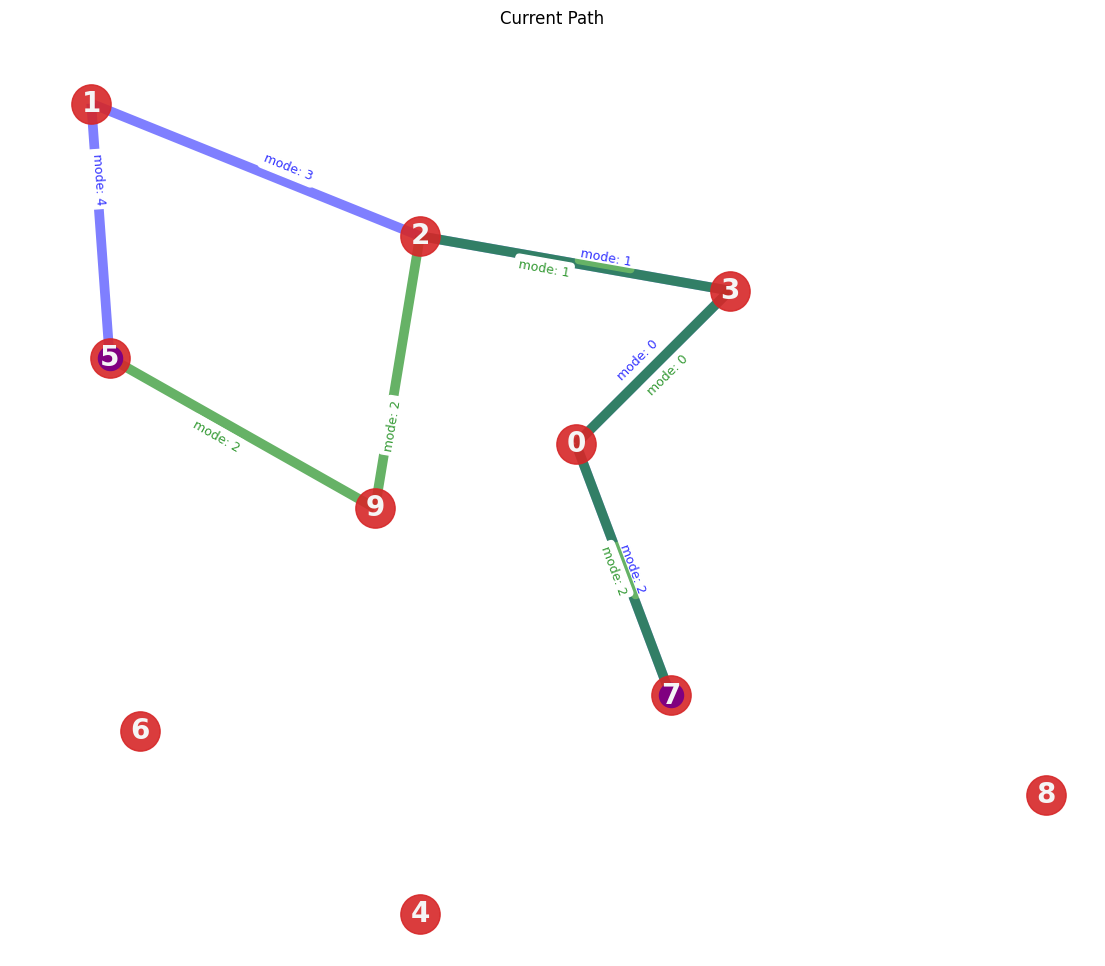

In [5]:
# AI makes a recommendation
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
task.step(ai_advice=ai_advice)

# User responds with a counter proposal based on hidden preferences
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
task.step(user_action=user_action)
task.display_path()

## Defining the AI

Given the components implemented above, you are now ready to implement your own AI-assistant. Below we've provided you with incompleted code for your AI-assistant. You will need to complete the two tasks below before your AI is functional.

## Task 1: Implement the user model <a class="anchor" id="task1"></a>

Consider the anonymous user who will have hidden preferences for how they weight the tradeoff among the available transportation modes for each $E_i$ of their journey. 

### Boltzmann model of rationality **[Insert information about Boltzmann Rationality here]**

We will model this tradeoff using the Boltzmann model of rationality. Namely, that users make decisions based on a policy of maximized utility
$$
\text{Decision} \propto \exp(\beta \cdot \text{utility}(\text{action}))
$$
where $\mathbf{\beta}$ is the user specific parameter vector.

For ease of interpretation, we will leverage the inverse of this model in this tutorial, i.e. that the anonymous user will seek to minimize the total journey cost. For our trip planning task, the costs associated with each segment of the journey will play into the user's overall preference for any given journey, so you can interpret $\mathbf{\beta}$ as weight parameters on the edge properties. We will let $\mathbf{\beta}^*$ denote the anonymous user's hidden but true parameter that the AI will want to learn. 

Then, for edge $e_{ij} = (d_{ij},p_{ij},t_{ij}) \in E_i$ with distance $d_{ij}$, price $p_{ij}$, and time $t_{ij}$, the user will weigh their preference as a linear combination:

$$
{\mathbf{\beta}^*}^{\intercal} e_{ij} = \beta_0 d_{ij} + \beta_1 p_{ij} + \beta_2 t_{ij}
$$


In [ ]:
def boltzmann_policy(all_paths,user_params):
    """
    Args:
      all_paths of type list(tuple): 
          The list of valid paths being considered by the user.
          
          Example: [[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
                    [(7, 0, 3), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
                    [(7, 0, 4), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)]]
          
      user_params of type numpy.array:
          The vector of the user's latent preference parameter, i.e. beta
          
          Example: np.array([0.05, 0.3, 0.65])

    Returns:
      (all_paths, action_probabilities)
      
      all_paths of type list: 
          Same as the input.
          
      path_probabilities of type list(numeric) or numpy.array: 
          The probabilities (pmf) of selecting the corresponding path as calculated
          according to Boltzmann rationality. Note that this must be normalized
          to sum to 1, so that it is a proper distribution.
          
          Example: [.5,.2,.3] or np.array([.5,.2,.3])
    """    
    all_costs =[]
    for path in all_paths:
        path_properties = np.array([task.look_up_cost(edge) for edge in path])
        
        path_costs = [_ for p in path_properties] #TODO: Replace _ with the Boltzmann user model 
        # solution: np.exp(user_params.dot(p))
        journey_cost = np.sum(path_costs)
        all_costs.append(journey_cost)

    cost_array = np.array(all_costs)
    path_probabilities = #TODO: make the cost array a proper distribution here 
    #solution: cost_array/np.sum(cost_array) # Have students implement this?
        
    return all_paths, path_probabilities

In [40]:
# run this cell to test if your function behaves correctly
test_params = np.array([1,1,1])
test_paths = [[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
              [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
              [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]]
expected_probs = np.array([1,1,1])/3
paths, probs = boltzmann_policy(test_paths,test_params)

assert paths == test_paths, f"output actions {paths} don't match the input actions {test_paths}"
assert all(np.isclose(probs,expected_probs)), f"expected={expected_probs}, got={probs}"

## Task 2: Implement the user inference <a class="anchor" id="task2"></a>

In [ ]:
def inference_engine(task_state):
    """
    input:
    
    output:
        
    """
    raise NotImplementedError("Inference has not been implemented")
    
    if not task_state.is_solved():
        # step 1: check which edge the user changed
        ai_advice = [s.get_itinerary() for s in obs.path_ai]
        changes = [s for s in obs.path_user if s.get_itinerary() not in ai_advice]
        
        for c in changes:
            cost_vec = c.get_costs()

            # step 2: Use Laplace Approx for posterior
            # Debug idea: change init value every time
            init_mean = self.param_dist.mean
            optim = minimize(self._log_posterior, init_mean,
                             args=(cost_vec,"L1"), method='BFGS')
            if not optim.success:
                print("Failed to minimize")
            w_map = optim.x/np.sum(optim.x)
            hessian = np.linalg.inv(optim.hess_inv)

            self.param_dist = multivariate_normal(mean=w_map,
                                                      cov=hessian)
            
def _log_posterior(self,w,a,regularizer=None):
#         w_mu = self.param_dist.mean
#         w_cov = self.param_dist.cov
#         log_prior = (w - w_mu).dot(np.linalg.inv(w_cov)).dot(w - w_mu)
#         if not np.isclose(np.sum(w),1):
#             w = w/np.sum(w)
        log_prior = self.param_dist.logpdf(w)
        log_likelihood = w.dot(a) 
        
        if regularizer == "L1":
            l1_reg = np.sum(np.abs(w))
            return -1*(log_prior + log_likelihood + np.log(l1_reg))
#         elif regularizer == "L2":    # Optimization yields invalid Hessian for covar matrix
#             l2_reg = np.sum(np.square(w))
#             return -1*(log_prior + log_likelihood + l2_reg)
            
        return -1*(log_prior + log_likelihood)

Run the following cell to inject these implementations into your AI-assistant

In [ ]:
model_overwrites = dict(policy_fn = boltzmann_policy,
                        inference = inference_engine)
simulatedUser = UserModel(model_overwrites)

ai_overwrites = dict(user_model = simulatedUser)
myAssistant = Assistant(ai_overwrites)

# ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
# task.step(ai_advice=ai_advice)
# simulatedUser.observe(task)
# # simulatedUser.observations
# simulatedUser.take_action()

## Task 3: Implement the AI-user interaction <a class="anchor" id="task3"></a>

The aim of the sequential interaction is to build a path between given starting point and destination and defining a mode of transfer for each route in it.

In [ ]:
# In case you didn't create the user above, here it is again:
# anonUser = crUser()

task.reset()
while not task.is_solved():
    # both agents observe the world
    
    # AI-assistant gives a recommendation
    myAssistant
    
    # User proposes counter journey or agrees to the recommendation
    user_action = anonUser.take_action()
    task.step(user_action = user_action)
    
    task.display_path()
    

# Code call examples (need delete later)

### AI's advice example

In [18]:
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

### User's action example

In [13]:
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)

### Displaying the current path

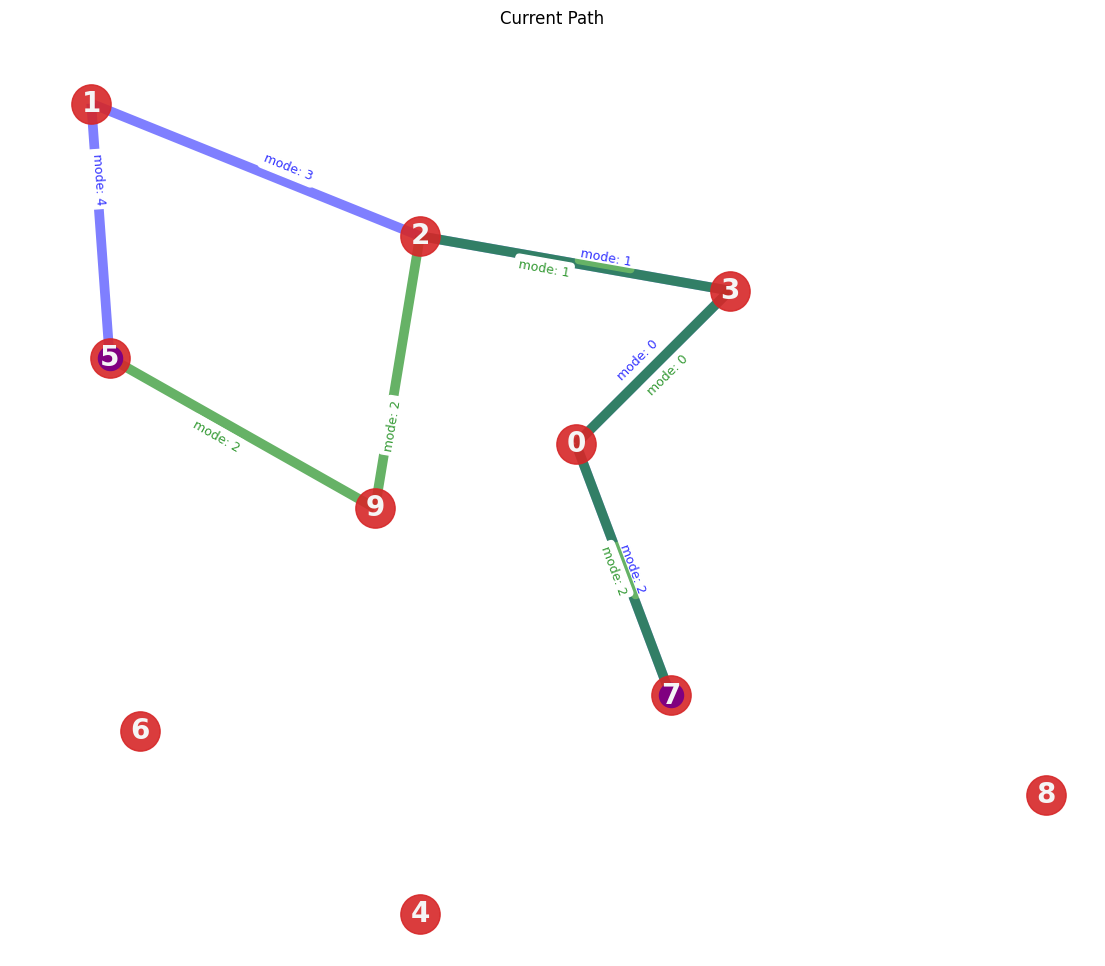

In [56]:
# AI makes a recommendation
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

# User responds with a counter proposal based on hidden preferences
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)
world.display_path()

In [15]:
# In our simplification, human is just a specific instance of a user model
# initiated with a stable/consistent param.
human = UserModel(user_param=np.array([.2,.2,.2]))
# human = User()
human.observe(world)
human.policy(ai_advice)

([[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]],
 array([9.83121887e-01, 1.64096278e-02, 4.68484866e-04]))

In [ ]:
user_action = human.take_action()

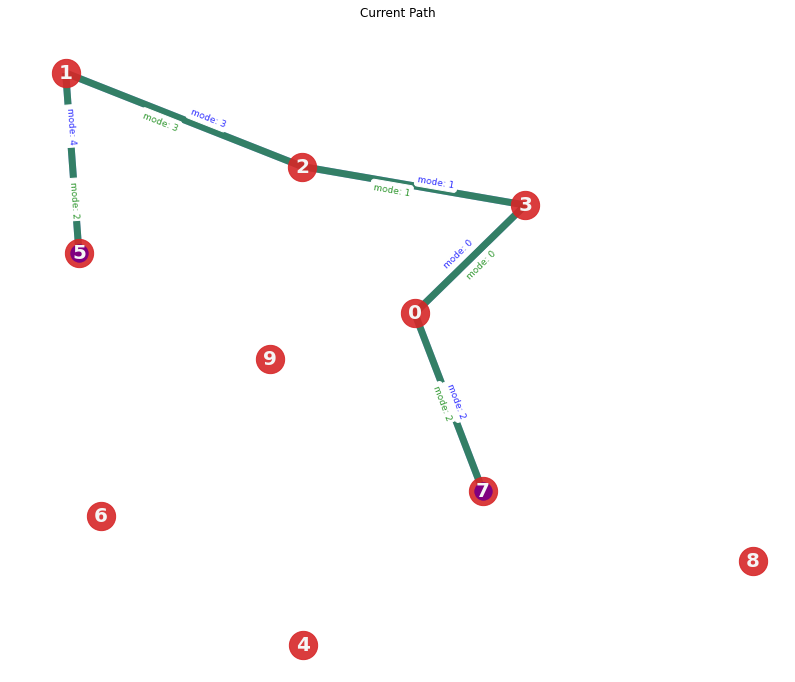

In [ ]:
world.step(user_action=user_action)
world.display_path()

AI assistant

In [ ]:
AI = Assistant()
AI.observe(world)